<a href="https://colab.research.google.com/github/AlirezaAhadipour/ECG_Heartbeat_Classification/blob/main/notebooks/ECG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
# !pip install -r ../requirements.txt

In [ ]:
import os

!pip install -q kaggle

# Set up Kaggle API
from google.colab import files

print("Please upload your kaggle.json file")
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

data_path = "/content/heartbeat_data"
!kaggle datasets download -d shayanfazeli/heartbeat -p /content/heartbeat_data --unzip


Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
 71% 70.0M/98.8M [00:00<00:00, 368MB/s]
100% 98.8M/98.8M [00:00<00:00, 373MB/s]


In [ ]:
## import required libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
## set random seeds to make results reproducible
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


I'll use `mitbih_train.csv` as the training set, which I'll break into train and validation sets, and use the `mitbih_test.csv` as the test set. I'll leave `ptbdb_normal.csv` and `ptbdb_abnormal.csv` as a holdout set.

In [ ]:
# # file paths
train_path = "heartbeat_data/mitbih_train.csv"
test_path = "heartbeat_data/mitbih_test.csv"

# load the data
df_train = pd.read_csv(train_path, header=None)
df_test = pd.read_csv(test_path, header=None)

# first few rows
df_train.head()


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A typical heartbeat is about 0.8 sec which is equal to 100 samples at a 125Hz sampling rate. The idea to extend that to 187 samples (or 1.5 sec equivalently) can be to also capture some surraounding context!

Next, let's verify that the last column is the targer (label) column. It should have 5 distinc values as `['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]`

In [ ]:
df_train[187].unique()

array([0., 1., 2., 3., 4.])

In [ ]:
# rename columns
num_features = df_train.shape[1] - 1
col_names = {i: f"feature_{i}" for i in range(num_features)}
col_names[num_features] = 'label'

df_train.rename(columns=col_names, inplace=True)
df_test.rename(columns=col_names, inplace=True)

df_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_train.shape

(87554, 188)

# Task 1: Data Processing

For this task, I limit everything to the training set and won't touch the test set to avoid any data leakage!

## EDA

In [ ]:
# basic info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, feature_0 to label
dtypes: float64(188)
memory usage: 125.6 MB


In [ ]:
print(f"# missing values: {df_train.isnull().sum().sum()}")

# missing values: 0


So far, it seems there is no missing values in the data, unless they are replaced by some specific values. we can plot the sequence and verify that. To do so, I'll plot 3 samples per class

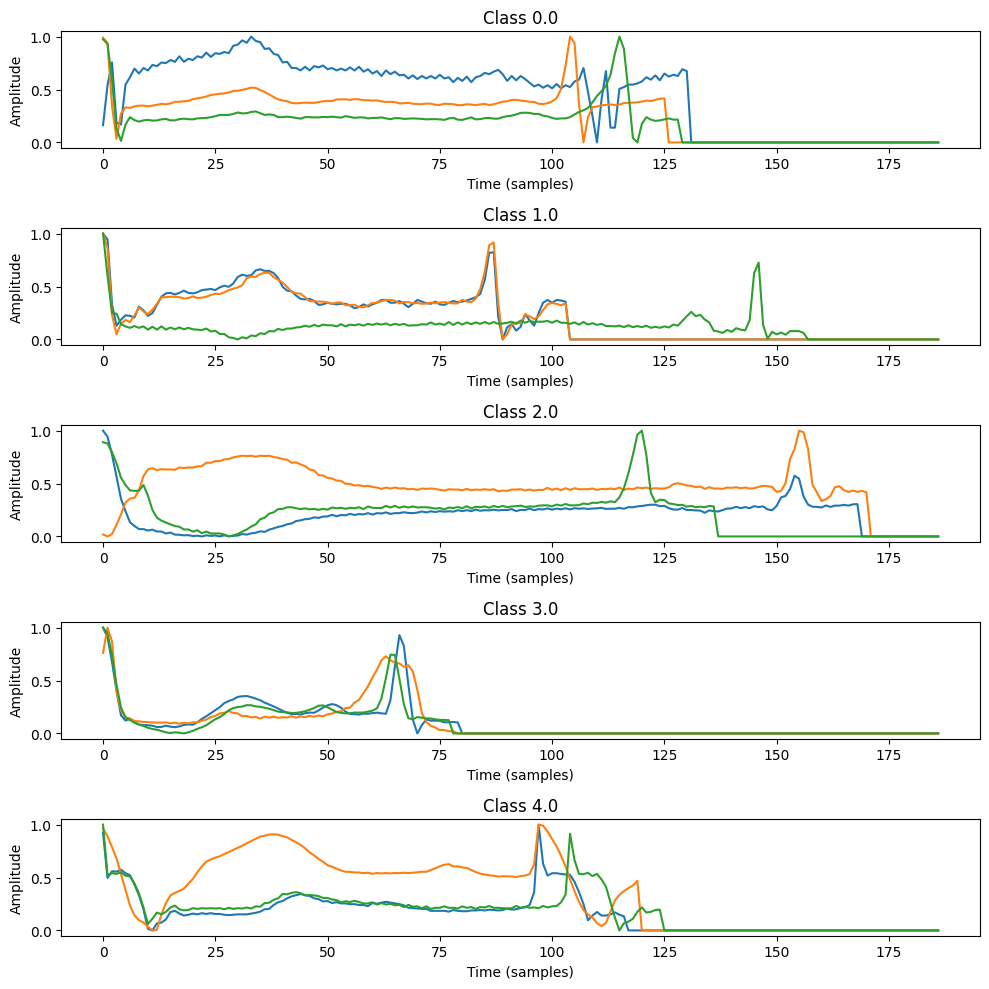

In [ ]:
classes = df_train['label'].unique()
num_classes = len(classes)

fig, axes = plt.subplots(nrows=num_classes, ncols=1, figsize=(10, 2*num_classes))

for i, label in enumerate(classes):
    samples = df_train[df_train['label'] == label].sample(3).iloc[:, :-1]

    for sample in samples.values:
        axes[i].plot(sample)

    axes[i].set_title(f"Class {label}")
    axes[i].set_xlabel('Time (samples)')
    axes[i].set_ylabel('Amplitude')

plt.tight_layout()

There are paddings added to the end of each sequnce, but there is no visually obvious missing values that require being filled (emputed).

One thing that is bothering me is that I thought each segment captures the R-R interval, and if so, all sequences should start from the maximum value (which is 1), but it is not the case for all plots above!!!

label
0.0    82.77
4.0     7.35
2.0     6.61
1.0     2.54
3.0     0.73
Name: proportion, dtype: float64


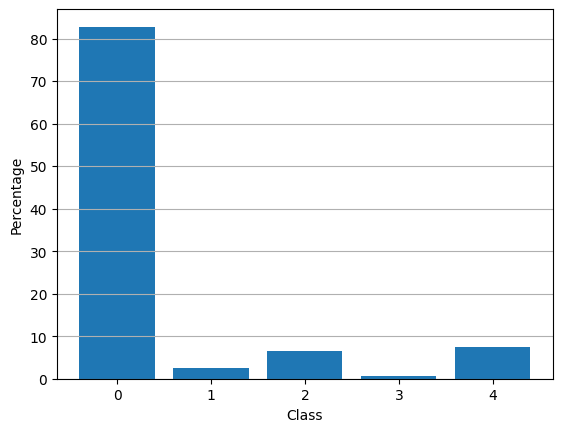

In [ ]:
## class distribution
class_counts = df_train['label'].value_counts(normalize=True).mul(100).round(2)
print(class_counts)

# plot class distribution
plt.figure()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.grid(axis='y')

So, the dataset is highly imbalanced, with the majority (~83%) being class 0 (`N`), and less than 1% for class 3 (`F`)

               mean       std
feature_0  0.890360  0.240909
feature_1  0.758160  0.221813
feature_2  0.423972  0.227305
feature_3  0.219104  0.206878
feature_4  0.201127  0.177058
feature_5  0.210399  0.171909
feature_6  0.205808  0.178481
feature_7  0.201773  0.177240
feature_8  0.198691  0.171778
feature_9  0.196757  0.168357


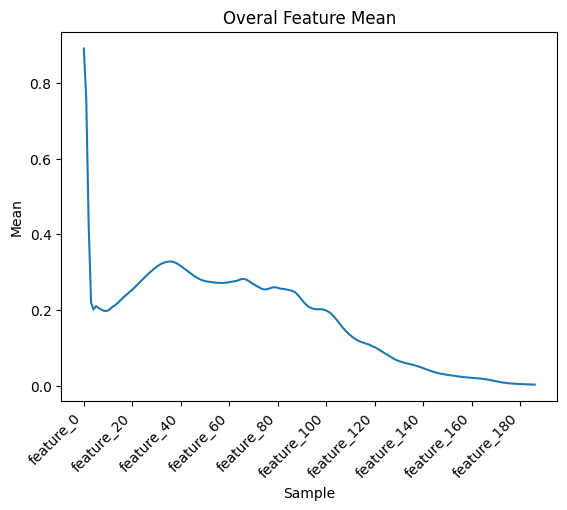

In [ ]:
## feature statistics
feature_stats = df_train.drop(columns=['label']).describe()
feature_stats = feature_stats.T
feature_stats = feature_stats[['mean', 'std']]
print(feature_stats[:10])

# plot the mean
plt.plot(feature_stats.index, feature_stats['mean'])
plt.xlabel('Sample')
plt.ylabel('Mean')
plt.title('Overal Feature Mean')
plt.xticks(ticks=range(0, 187, 20), rotation=45, ha='right')
plt.show()

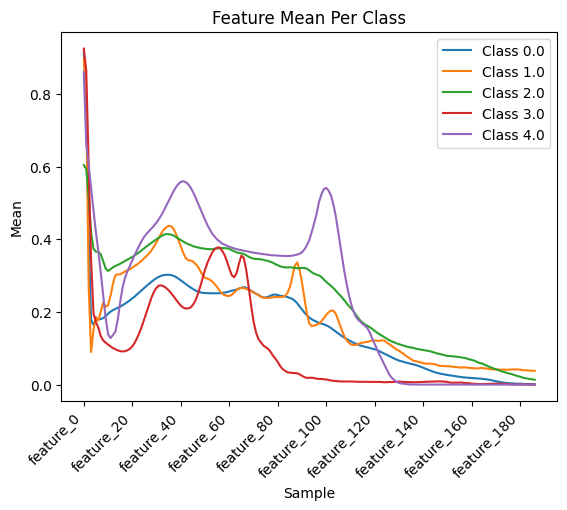

In [ ]:
## per class
feature_stats_per_class = df_train.groupby('label').mean().T

for cls in df_train['label'].unique():
    plt.plot(feature_stats_per_class.index, feature_stats_per_class[cls], label=f"Class {cls}")

plt.xlabel('Sample')
plt.ylabel('Mean')
plt.xticks(ticks=range(0, 187, 20), rotation=45, ha='right')
plt.title('Feature Mean Per Class')
plt.legend()


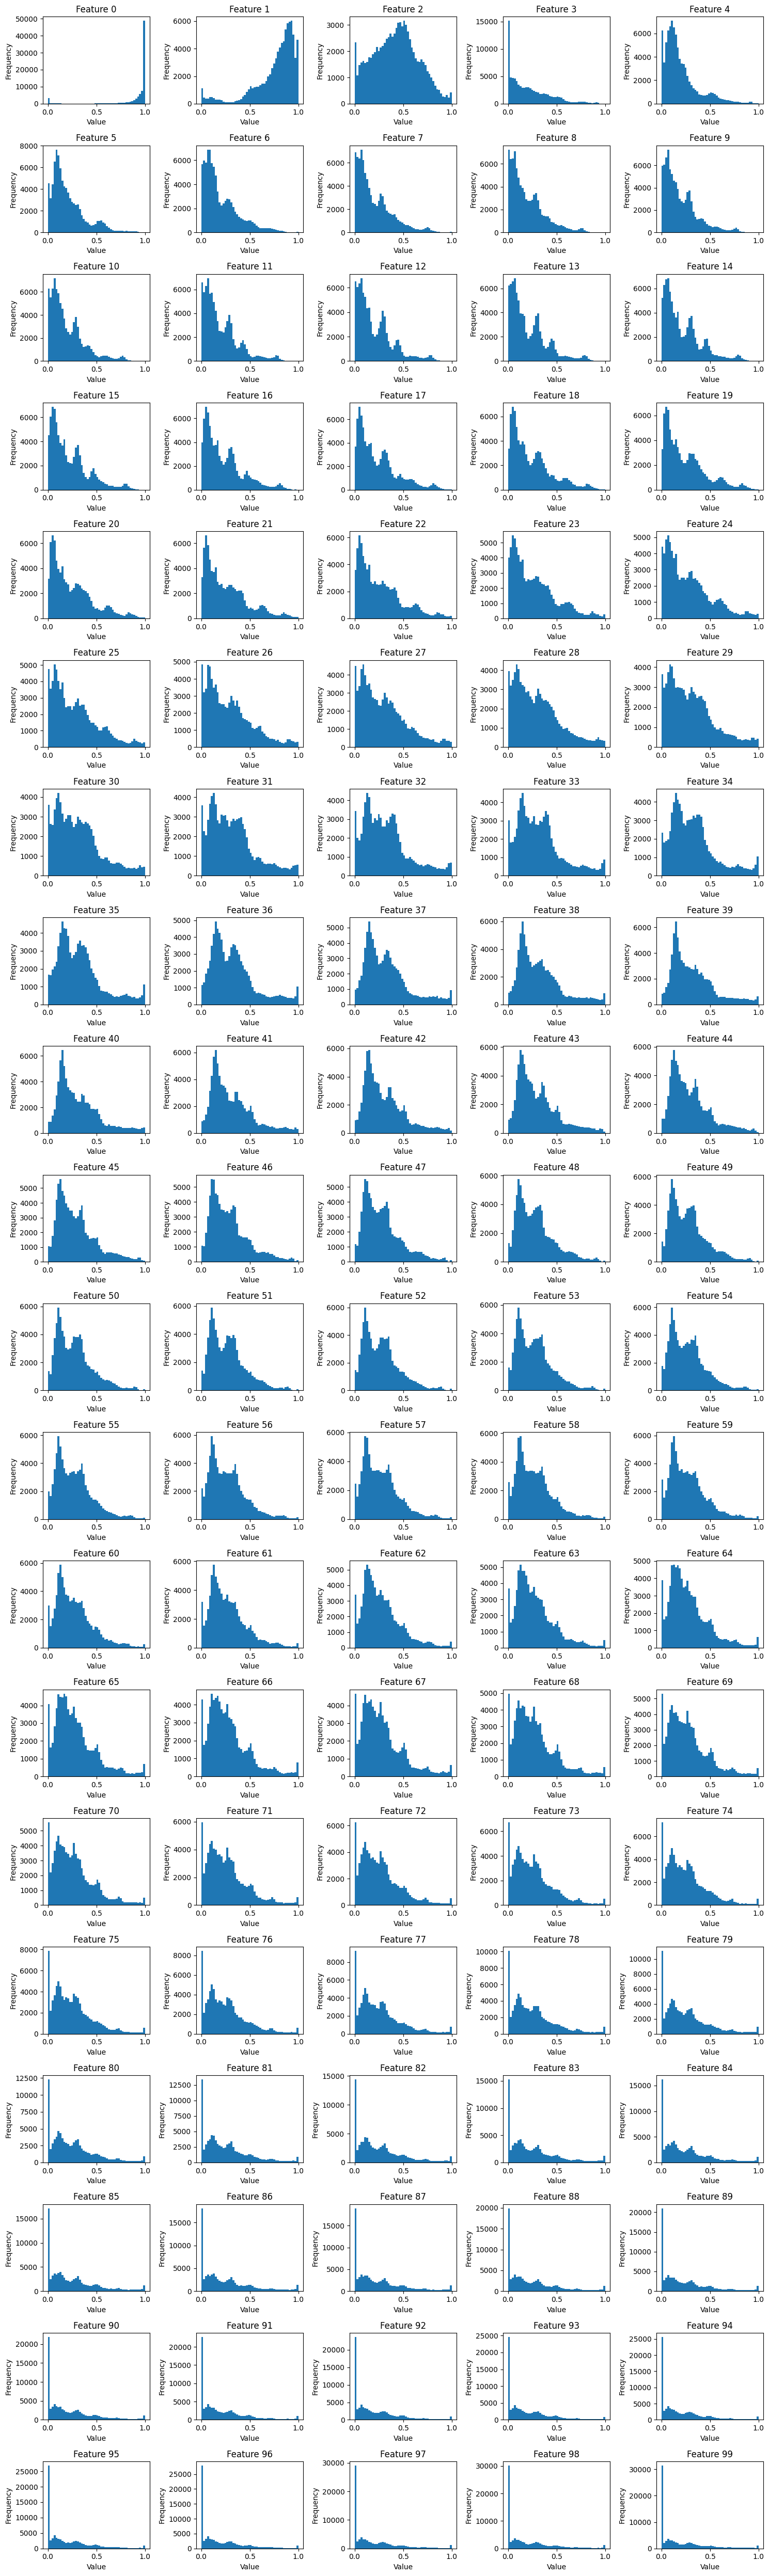

In [ ]:
## feature distribution
feature_subset = df_train.drop(columns=['label']).iloc[:, :100]  # first 100 features
fig, axes = plt.subplots(20, 5, figsize=(15, 50))

for i, ax in enumerate(axes.flat):
    ax.hist(feature_subset.iloc[:, i], bins=50)
    ax.set_title(f"Feature {i}")
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()

Next, let's see if there is any correlation between different features

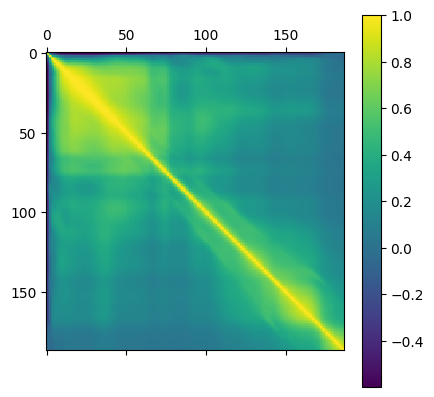

In [ ]:
## feature correlation
corr = df_train.drop(columns=['label']).corr()

# plot
plt.matshow(corr)
plt.colorbar()

plt.tight_layout()

As expected, there is a strong diagonal correlation, since each feature is perfectly correlated with itself. The heatmap also reveals a strong correlation among the first ~60 features, indicating similar signal patterns in that range. Additionally, features that are closer together tend to have higher correlation than those further apart, which is expected in time-series data.

We can visualize it further per class

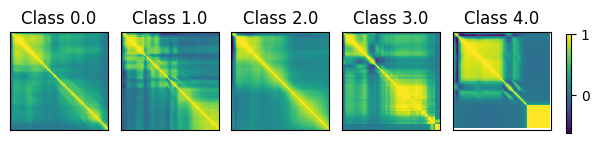

In [ ]:
## per class
classes = df_train['label'].unique()

fig, axes = plt.subplots(1, len(classes))

for i, cls in enumerate(classes):
    corr = df_train[df_train['label'] == cls].drop(columns=['label']).corr()

    im = axes[i].matshow(corr)
    axes[i].set_title(f"Class {cls}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])

fig.colorbar(im, ax=axes, fraction=0.01, pad=-0.15)
plt.tight_layout()


We can see that feature correlations vary significantly across different classes, indicating that different classes have distinct dependencies among features

## Data Augmentation

As seen before, the dataset is highly imbalanced. While data augmentation increases the number of training examples, it does not inherently balance the dataset. However, by generating variations of underrepresented classes, it can help the model generalize better and reduce overfitting.

One straightforward yet effective time-series augmentation technique is adding Gaussian noise to the signal (jittering). This method is minimally invasive, while making the model more robust to noise. If applied with an appropriate noise level, it is unlikely to shift a signal from one class to another. So the level of noise is a hyper parameter itself to be effective while not distorting the data

A critical point to consider is that both the original signal and its augmented version must reside in the same dataset, either training or validation. Otherwise, data leakage can occur, where information from the training set unintentionally influences validation performance, leading to overly optimistic results.

In [ ]:
# split into train and val sets
train_set, val_set = train_test_split(df_train, test_size=0.2, stratify=df_train['label'], random_state=42)

# std
feature_std = train_set.drop(columns=["label"]).replace(0, np.nan).std().mean()

# noise level
sigma = 0.01 * feature_std

def augment_signal(signal, sigma):
    augmented_signal = signal.copy()
    nonzero_indx = np.where(signal != 0)[0]  # non-padded index

    noise = np.random.normal(0, sigma, size=len(nonzero_indx))
    augmented_signal[nonzero_indx] += noise

    # min-max scale
    min_val = augmented_signal[nonzero_indx].min()
    max_val = augmented_signal[nonzero_indx].max()
    augmented_signal[nonzero_indx] = (augmented_signal[nonzero_indx] - min_val) / (max_val - min_val)

    return augmented_signal

train_augmented = train_set.copy()
for i in range(train_augmented.shape[0]):
    train_augmented.iloc[i, :-1] = augment_signal(train_augmented.iloc[i, :-1].values, sigma)


final_train_set = pd.concat([train_set, train_augmented], ignore_index=True)
final_train_set.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,label
0,0.053191,0.162234,0.292553,0.441489,0.521277,0.627660,0.747340,0.784574,0.779255,0.795213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.974265,0.867647,0.591912,0.312500,0.128676,0.022059,0.000000,0.014706,0.044118,0.055147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.752322,0.637771,0.540248,0.411765,0.272446,0.151703,0.086687,0.023220,0.024768,0.043344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.977654,0.916201,0.614525,0.364991,0.327747,0.294227,0.240223,0.210428,0.178771,0.152700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.015464,0.000000,0.033505,0.108247,0.203608,0.269330,0.349227,0.444588,0.511598,0.600515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [ ]:
df_train.shape, train_set.shape, train_augmented.shape, final_train_set.shape

((87554, 188), (70043, 188), (70043, 188), (140086, 188))

## Feature Engineering

We can extract statistical features that represent each ECG segment, such as mean, median, standard deviation, skewness, kurtosis, autocorrelation, and entropy measures (e.g., sample or permutation entropy). These features can then be used to train a traditional classification model.

However, as a starting point, I prefer to leverage deep learning models, which can automatically learn relevant features from the raw data, rather than relying on manually engineered features.

## Handle Missing Values

In [ ]:
print(f"# missing values, train set: {df_train.isnull().sum().sum()}")
print(f"# missing values, test set: {df_test.isnull().sum().sum()}")

# missing values, train set: 0
# missing values, test set: 0


As can be seen, there are no missing values in the training and test sets; however if missing values were present, different strategies would be needed depending on their distribution:
- if missing values are sparse and isolated, we can simply fill them using linear interpolation
- if there are consecutive missing values (gaps), depending on the length of the gap, we can either fill them using linear (or spline) interpolation for example (or even use more advanced techniques like training ARIMA or LSTM models to predict the missing values (fill the gaps)), or if the gap is too large and filling will introduce too much uncertainty, simply dropping those samples might be a better choice

# Task 2: Model Training & Fine-tuning

As mentioned before, I did not perform any feature engineering and decided to start with deep learning models which are pretty good at feature extraction. Since we are dealing with raw ECG signals, a CNN (Convolutional Neural Net) would be a great choice as it automatically extract features from raw signal and can capture local patterns in the signal. To be more specific, I'll start with a 1D-CNN (1 Dimensional CNN) model.

In [ ]:
## prepare data for training
X_train = final_train_set.iloc[:, :-1].values
y_train = final_train_set.iloc[:, -1].values
y_train_copy = y_train.copy()   # create a copy for later use in calculating the class weight

X_val = val_set.iloc[:, :-1].values
y_val = val_set.iloc[:, -1].values

X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

# reshape (samples, time_steps, channels)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# convert labels to categorical
y_train = to_categorical(y_train, num_classes=5)
y_val = to_categorical(y_val, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

Let's start with a base model, which is simply two layers of CNN stacking on top of each other, and see how it performs, and if needed, add more components to the model to improve the performance later on

In [ ]:
# CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=32)


Epoch 1/2
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9381 - loss: 0.2322 - val_accuracy: 0.9732 - val_loss: 0.0988
Epoch 2/2
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.9744 - loss: 0.0889 - val_accuracy: 0.9812 - val_loss: 0.0703


685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18118
           1       0.94      0.67      0.79       556
           2       0.97      0.91      0.94      1448
           3       0.77      0.72      0.74       162
           4       0.99      0.98      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.93      0.86      0.89     21892
weighted avg       0.98      0.98      0.98     21892



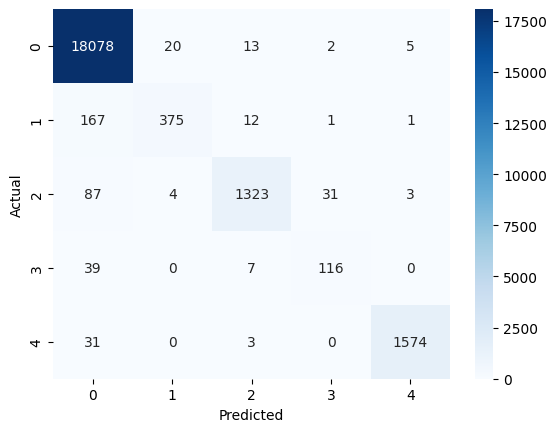

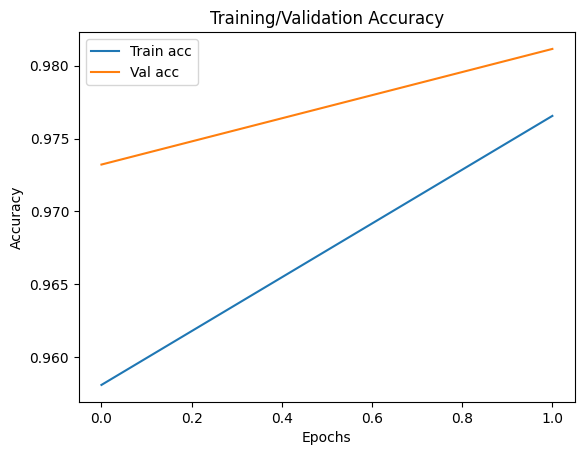

In [ ]:
## evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# classification report
print(classification_report(y_true_classes, y_pred_classes))

# confusion matrix
sns.heatmap(confusion_matrix(y_true_classes, y_pred_classes), annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# accuracy
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training/Validation Accuracy')
plt.show()


Well, the total performance is pretty good for the first try. The performance for classes 1 and 3 is low, and that's because these two classes have the least number of training examples.

To improve the performance, let's give more weight to the classes with fewer number of training examples using `class weight`.This way, the model gives more weight to these classes, and if misclassified, it penalizes more.

Also, I decreased the learning rate, increased the number of epochs for training, and added early stopping to avoid overfitting.



In [ ]:
# compute class weights
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train_copy),y=y_train_copy)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

# compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    # optimizer=SGD(learning_rate=0.001, nesterov=True, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2, batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/2
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.6835 - loss: 0.6410 - val_accuracy: 0.8511 - val_loss: 0.4171
Epoch 2/2
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.8448 - loss: 0.3028 - val_accuracy: 0.8987 - val_loss: 0.2817


685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     18118
           1       0.28      0.84      0.42       556
           2       0.87      0.90      0.88      1448
           3       0.19      0.88      0.31       162
           4       0.94      0.98      0.96      1608

    accuracy                           0.90     21892
   macro avg       0.65      0.90      0.70     21892
weighted avg       0.96      0.90      0.92     21892



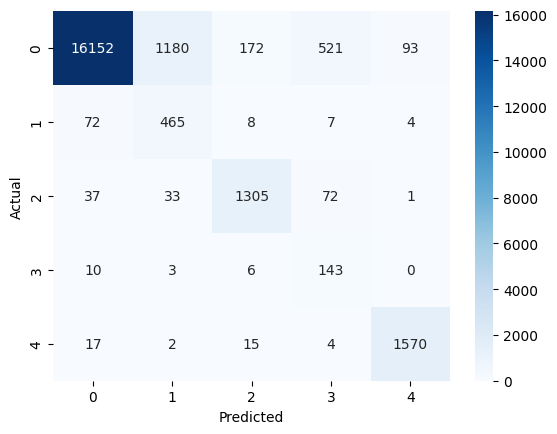

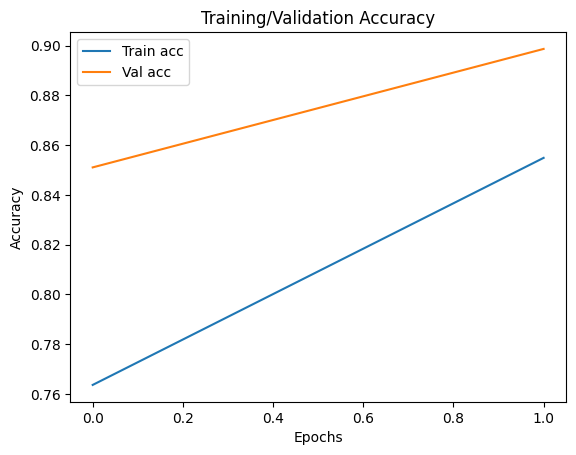

In [ ]:
## evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# classification report
print(classification_report(y_true_classes, y_pred_classes))

# confusion matrix
sns.heatmap(confusion_matrix(y_true_classes, y_pred_classes), annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# accuracy
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training/Validation Accuracy')
plt.show()


Honestly, I did not expect that!!!